<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week2/digits_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example 7:  Handwritten digits
#### Dataset Description:
The dataset consists of 2950 black and white images of handwritten digits represented as numerical arrays.
Each image is a 16x16 grid where pixel values are either -1 (black) or 1 (white).
- The first column in the dataset contains the class label, which represents the digit (1-10). 10 is the label for gigit 0.
- The remaining columns contain pixel values for the respective image.

In [3]:
# load the perceptron_library.py file into google colab
import urllib.request

url = 'https://raw.githubusercontent.com/reitezuz/18NES1-2025-/refs/heads/main/week2/perceptron_library.py'
filename = 'perceptron_library.py'
urllib.request.urlretrieve(url, filename)


('perceptron_library.py', <http.client.HTTPMessage at 0x7b0fcd681c90>)

In [4]:
# import libraries
from perceptron_library import *
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt


### Auxiliary functions


In [5]:
im_size = 16

def load_digits_data():
    """ Load image data from a CSV file hosted on GitHub into numpy arrays """
    github_url = "https://github.com/reitezuz/18NES1-2025-/blob/55cb9d26187c960873bf576ffdfdff0f658e662a/week2/OcrData.csv"
    url = github_url.replace("github.com", "raw.githubusercontent.com").replace("blob/", "")
    df = pd.read_csv(url, header=None)
    labels = df.iloc[:, 0].values   # First column is the class label
    inputs = df.iloc[:, 1:].values  # Remaining columns are features (-1, 1)
    return inputs, labels

def visualize_digit(X, labels, index):
    """ Visualize the i-th row of the data as a 50x50 black and white image """
    image = X[index].reshape(im_size, im_size)  # Reshape to im_size x im_size
    digit = labels[index]
    plt.figure(figsize=(2,2))         # Figure size
    image = np.fliplr(np.rot90(image, k=3))
    image = -image
    plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.title(f"Diget Image at Index {index} ... {digit}")
    plt.axis('off')
    plt.show()


def add_noise(X, alpha=0.01):
    """ Add salt & pepper noise to the dataset and apply median filtering """
    from scipy.ndimage import median_filter
    X = (X + 1) / 2  # Convert from [-1,1] to [0,1]
    X_noisy = X.copy()
    X_denoised = X.copy()

    for i in range(X.shape[0]):
        img = X[i].reshape(im_size, im_size)

        # Add salt & pepper noise
        noisy_img = img.copy()
        noise = np.random.choice([0, 1, -1], size=img.shape, p=[1 - alpha, alpha / 2, alpha / 2])
        noisy_img[noise == -1] = 0  # Salt (white)
        noisy_img[noise == 1] = 1   # Pepper (black)

        # Apply median filter
        denoised_img = median_filter(noisy_img, size=3)

        # Flatten back to vector form
        X_noisy[i] = noisy_img.flatten()
        X_denoised[i] = denoised_img.flatten()

    X_noisy = X_noisy * 2 - 1  # Convert back to [-1,1]
    X_denoised = X_denoised * 2 - 1  # Convert back to [-1,1]

    return X_noisy, X_denoised

def show_noisy_and_denoised(X_original, X_noisy, X_denoised, index):
    """ Display original, noisy, and denoised images side by side """
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    original_img = X_original[index].reshape(im_size, im_size)
    original_img = - np.fliplr(np.rot90(original_img , k=3))
    noisy_img = X_noisy[index].reshape(im_size, im_size)
    noisy_img = - np.fliplr(np.rot90(noisy_img , k=3))
    denoised_img = X_denoised[index].reshape(im_size, im_size)
    denoised_img = - np.fliplr(np.rot90(denoised_img , k=3))

    axes[0].imshow(original_img, cmap='gray', vmin=-1, vmax=1)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(noisy_img, cmap='gray', vmin=-1, vmax=1)
    axes[1].set_title("Noisy Image")
    axes[1].axis('off')

    axes[2].imshow(denoised_img, cmap='gray', vmin=-1, vmax=1)
    axes[2].set_title("Denoised Image")
    axes[2].axis('off')

    plt.show()

def run_example_multiple_times(experiment_results, inputs, test_inputs1, test_inputs2, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=100):
    times = []
    errors = []
    test_errors1 = []
    test_errors2 = []
    epoch_counts = []

    for _ in range(num_runs):
        perceptron = Perceptron(weights, bias, binary)
        start_time = time.time()
        if variant == 'rosenblatt best':
            perceptron.rosenblatt_iterative_best(inputs, true_outputs, learning_rate, epochs, False)  # Suppress individual run progress
        elif variant == 'rosenblatt iterative':
            perceptron.rosenblatt_iterative(inputs, true_outputs, learning_rate, epochs, False)
        elif variant == 'rosenblatt batch':
            perceptron.rosenblatt_batch(inputs, true_outputs, learning_rate, epochs, False)
        else:
            perceptron.hebbian(inputs, true_outputs, False)
        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = perceptron.forward(inputs)
        test_outputs1 = perceptron.forward(test_inputs1)
        test_outputs2 = perceptron.forward(test_inputs2)
        error = perceptron_error(true_outputs, real_outputs)
        test_error1 = perceptron_error(true_outputs, test_outputs1)
        test_error2 = perceptron_error(true_outputs, test_outputs2)

        times.append(elapsed_time)
        errors.append(error)
        test_errors1.append(test_error1)
        test_errors2.append(test_error2)
        epoch_counts.append(perceptron.epochs)

    avg_time = np.mean(times)
    avg_error = np.mean(errors)
    avg_test_error1 = np.mean(test_errors1)
    avg_test_error2 = np.mean(test_errors2)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'Error': avg_error,
        'Test Error 1': avg_test_error1,
        'Test Error 2': avg_test_error2,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': perceptron.weights, #Note: Weights and bias are from the last run.
        'Bias': perceptron.bias,
        'Data Description': data_description
    }
    experiment_results.loc[len(experiment_results)] = results
    return perceptron

### Analyze the data:

In [6]:
# Load the data:
[inputs, labels] = load_digits_data()

print(np.shape(inputs), np.shape(labels))
print(np.max(inputs), np.min(inputs), np.max(labels), np.min(labels))



(2950, 256) (2950,)
1 -1 10 1


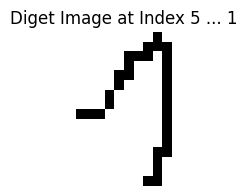

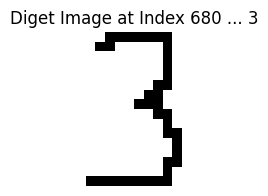

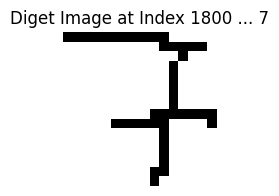

In [7]:
# Visualize some digits:
for index in [5, 680, 1800]:
    visualize_digit(inputs, labels, index)

Create the testing set by adding noise and denoising:
- experiment with the level of noise, alpha

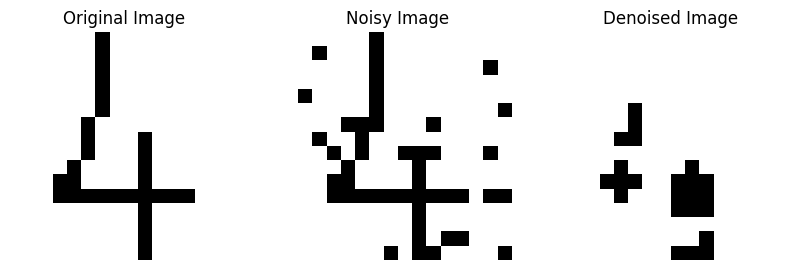

In [8]:
[inputs_noisy, inputs_denoised] = add_noise(inputs, alpha=0.1)
index = 2180
show_noisy_and_denoised(inputs, inputs_noisy, inputs_denoised, index)

### Example: Train the Perceptron to recognize a digit

In [9]:
# DataFrame to store the results for comparisons
experiment_results_let = pd.DataFrame(columns=['Error', 'Test Error 1', 'Test Error 2', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

- set the parametrers, run the experiment and observe the results:

In [10]:
digit_index = 10 # 1...10
alpha = 0.1       # level of noise in the testing data

# Preprocess the data:
[inputs, labels] = load_digits_data()
[inputs_noisy, inputs_denoised] = add_noise(inputs, alpha=alpha)
true_outputs = np.where(labels == digit_index, 1, -1)
data_description = "Digit " + str(digit_index) + f" {(sum(true_outputs == 1))}"

# Set Perceptron parameters:
weights = np.zeros(inputs.shape[1])
bias = 0
binary = False
epochs = 200
learning_rate = 1
print_progress = False
variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

# run the experiment:
perceptron = run_example_multiple_times(experiment_results_let, inputs, inputs_noisy, inputs_denoised, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=1)

print("\nExperiment Results:")
experiment_results_let


Experiment Results:


,Error,Test Error 1,Test Error 2,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.0,35.0,228.0,7.0,1.612401,rosenblatt iterative,1,200,"[3.0, 3.0, 3.0, 3.0, 3.0, 9.0, 9.0, 7.0, 7.0, ...",-3,Digit 10 300


- visualize the misclassified digits:

In [ ]:
for inputs1 in [inputs, inputs_noisy, inputs_denoised]:
    outputs = perceptron.forward(inputs1)

    # Find misclassified digits
    misclassified_indices = []
    outputs = perceptron.forward(inputs1)
    for i in range(len(outputs)):
        if outputs[i] != true_outputs[i]:
            misclassified_indices.append(i)

    # Visualize misclassified digits
    print("Misclassified Digits:")
    for index in misclassified_indices[:5]:
        visualize_digit(inputs1, labels, index)
        print(f"  Predicted: {1 if outputs[index] > 0 else -1}, Actual: {true_outputs[index]}")

Misclassified Digits:
Misclassified Digits:
Misclassified Digits:


- compare the results for the digits:

In [ ]:
alpha = 0.1
# DataFrame to store the results for comparisons
experiment_results_l = pd.DataFrame(columns=['Error', 'Test Error 1', 'Test Error 2', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
for digit_index in range(1,11):
    print(digit_index)
    [inputs, labels] = load_digits_data()
    [inputs_noisy, inputs_denoised] = add_noise(inputs, alpha=alpha)
    true_outputs = np.where(labels == digit_index, 1, -1)
    data_description = "Digit " + str(digit_index % 10) + f" {(sum(true_outputs == 1))}"
    num_runs = 10

    # Set Perceptron parameters:
    weights = np.zeros(inputs.shape[1])
    bias = 0
    binary = False
    epochs = 200
    learning_rate = 1
    print_progress = False
    variant = 'rosenblatt iterative' # 'rosenblatt best','rosenblatt iterative', 'rosenblatt batch', 'hebbian'

    # run the experiment:
    run_example_multiple_times(experiment_results_l, inputs, inputs_noisy, inputs_denoised, true_outputs, epochs, weights, bias, binary, learning_rate, print_progress, variant, data_description, num_runs=num_runs)

print("\nExperiment Results:")
experiment_results_l

1
2
3
4
5
6
7
8
9
10

Experiment Results:


,Error,Test Error 1,Test Error 2,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.0,93.7,222.4,82.9,7.302421,rosenblatt iterative,1,200,"[63.0, 27.0, 7.0, -13.0, 17.0, 1.0, 1.0, -19.0...",-131,Digit 1 300
1,0.0,68.5,185.3,18.2,1.755910,rosenblatt iterative,1,200,"[7.0, 13.0, 17.0, 47.0, 13.0, 11.0, -11.0, -15...",-23,Digit 2 300
2,0.0,225.1,285.1,148.9,12.938169,rosenblatt iterative,1,200,"[28.0, 40.0, 44.0, -44.0, -18.0, 28.0, -8.0, -...",-184,Digit 3 300
3,0.0,64.0,168.4,24.1,2.082486,rosenblatt iterative,1,200,"[5.0, -1.0, -29.0, -25.0, 5.0, 7.0, 21.0, 7.0,...",-25,Digit 4 300
4,66.6,313.5,347.5,200.0,17.497393,rosenblatt iterative,1,200,"[-58.0, 108.0, 10.0, -16.0, -30.0, 118.0, -38....",-828,Digit 5 250
5,0.0,97.6,228.3,31.0,2.708504,rosenblatt iterative,1,200,"[4.0, 20.0, 0.0, -4.0, 10.0, 22.0, 10.0, 22.0,...",-28,Digit 6 300
6,0.0,116.1,200.2,34.5,3.096686,rosenblatt iterative,1,200,"[39.0, 47.0, 51.0, 45.0, -11.0, -11.0, -7.0, -...",-31,Digit 7 300
7,0.0,96.3,193.0,36.3,3.143123,rosenblatt iterative,1,200,"[6.0, -20.0, -4.0, -2.0, -4.0, -40.0, -28.0, 4...",54,Digit 8 300
8,0.0,166.7,257.2,73.4,6.427755,rosenblatt iterative,1,200,"[-9.0, -45.0, -1.0, 1.0, 31.0, -25.0, 37.0, 7....",-25,Digit 9 300
9,0.0,26.9,225.0,9.3,0.871760,rosenblatt iterative,1,200,"[2.0, 4.0, 6.0, 6.0, 2.0, 8.0, 8.0, 10.0, 6.0,...",-2,Digit 0 300
